In [ ]:
# Instalacja biblioteki livelossplot do wizualizacji postępu uczenia modelu
!pip install livelossplot

In [ ]:
# Importowanie potrzebnych bibliotek
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from livelossplot import PlotLossesKeras

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
# Podłączenie dysku Google w środowisku Colab do łatwego dostępu do plików
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ścieżka do folderu z obrazami na Dysku Google
drive_folder_path = '/content/drive/My Drive/generated_images'

# Wczytanie listy plików w wybranym folderze
files_in_drive_folder = os.listdir(drive_folder_path)

# Inicjalizacja listy do przechowywania wczytanych obrazów
loaded_images = []

# Ładowanie obrazów z folderu do listy
for file_name in files_in_drive_folder:
    file_path = os.path.join(drive_folder_path, file_name)
    if os.path.isfile(file_path):
        image = cv2.imread(file_path)
        if image is not None:
            loaded_images.append(image)

# Konwersja listy obrazów na tablicę numpy i normalizacja pikseli
custom_dataset = np.array(loaded_images)
custom_dataset = custom_dataset.astype('float32') / 255.

# Wyświetlenie informacji o wymiarach zbioru danych
print("Kształt zbioru danych:", custom_dataset.shape)

Kształt zbioru danych: (20020, 40, 40, 3)


In [ ]:
# Podział danych na zbiory treningowy i testowy
x_train, x_test = train_test_split(custom_dataset, test_size=0.2)
print("Kształt x_train:", x_train.shape)
print("Kształt x_test:", x_test.shape)

Kształt x_train: (16016, 40, 40, 3)
Kształt x_test: (4004, 40, 40, 3)


In [ ]:
# Definicja klasy autoenkodera konwolucyjnego
class AutoencoderCNN(Model):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        # Budowa enkodera (kompresji danych)
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(40, 40, 3)),
            layers.BatchNormalization(),
            layers.Conv2D(258, (3, 3), activation='relu', padding='same'),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPool2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='relu', padding='same')
        ])

        # Budowa dekodera (odkodowywanie danych)
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Inicjalizacja, kompilacja i trenowanie modelu autoenkodera
autoencoder = AutoencoderCNN()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

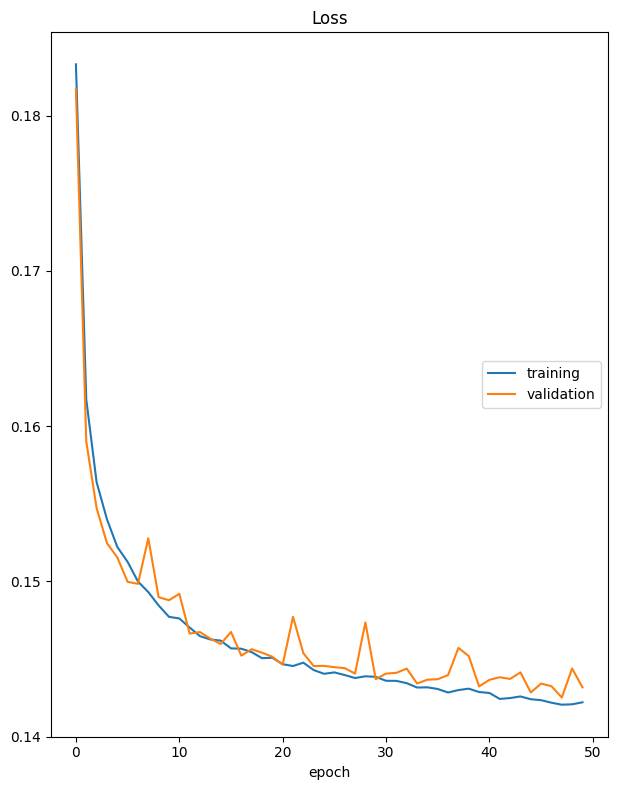

Loss
	training         	 (min:    0.142, max:    0.183, cur:    0.142)
	validation       	 (min:    0.143, max:    0.182, cur:    0.143)
126/126 [==============================] - 13s 105ms/step - loss: 0.1422 - val_loss: 0.1432


In [ ]:
# Trenowanie autoenkodera
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[PlotLossesKeras()])

In [ ]:
# Przetwarzanie obrazów testowych przez enkoder i dekoder
encoded_imgs = autoencoder.encoder(x_test[:1000,:,:]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

# Wyświetlenie wymiarów zakodowanych obrazów
print(encoded_imgs.shape)

(1000, 10, 10, 3)


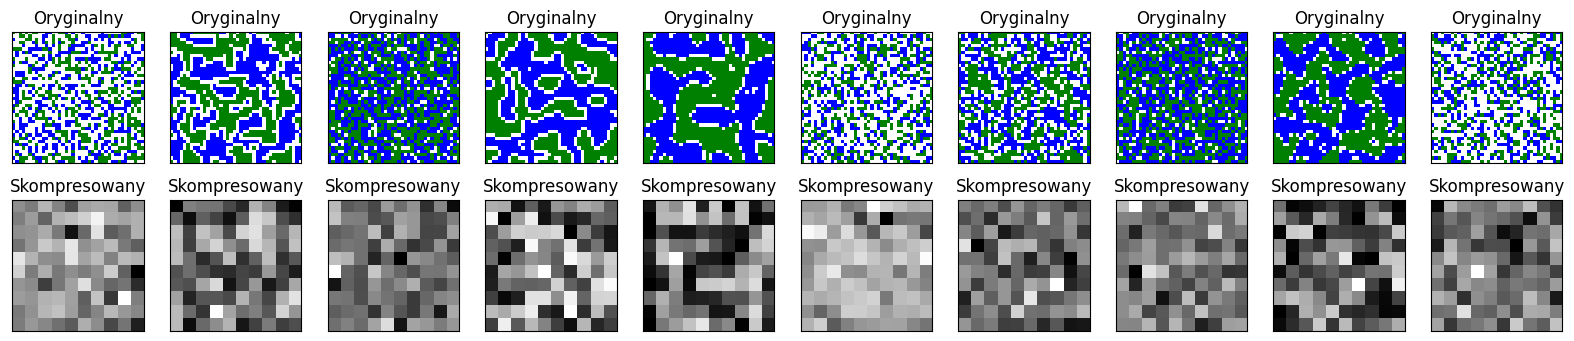

In [ ]:
# Wizualizacja oryginalnych i skompresowanych obrazów
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Wizualizacja oryginalnego obrazu
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Oryginalny")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Wizualizacja skompresowanego obrazu
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i][:, :, 0], cmap='gray')
    plt.title("Skompresowany")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


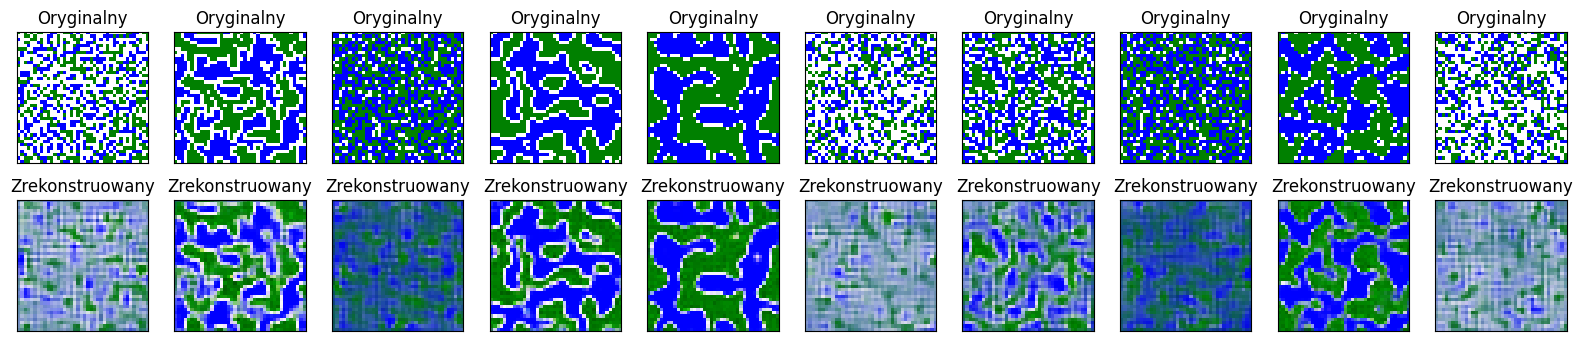

In [ ]:
# Wizualizacja oryginalnych i zrekonstruowanych obrazów
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Wizualizacja oryginalnego obrazu
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Oryginalny")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Wizualizacja zrekonstruowanego obrazu
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Zrekonstruowany")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Przygotowanie danych do analizy klastrów
num_samples, height, width, channels = encoded_imgs.shape
encoded_imgs_2d = encoded_imgs.reshape(num_samples, height * width * channels)

# Definicja parametrów dla t-SNE i KMeans
optimal_k = 5
perplexity_value = 20

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


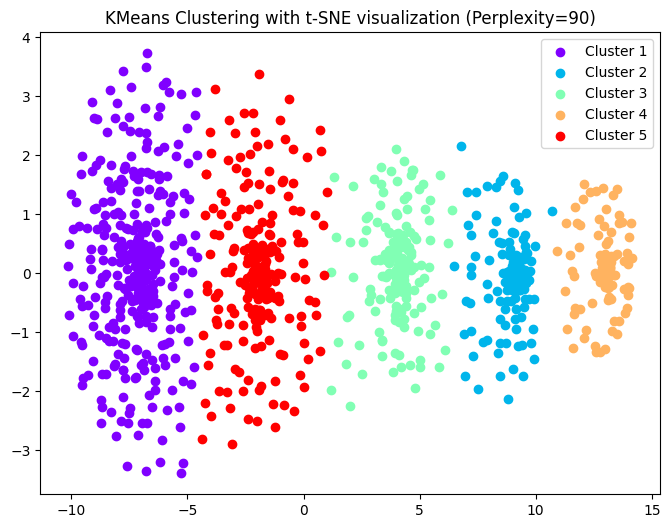

In [ ]:
# Wykorzystanie algorytmu t-SNE do redukcji wymiarowości danych
# Ustawiamy liczbę komponentów na 2, aby uzyskać dwuwymiarową reprezentację
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
# Przekształcenie zakodowanych obrazów do przestrzeni 2D
tsne_results = tsne.fit_transform(encoded_imgs_2d)

# Implementacja algorytmu KMeans do grupowania danych
# Wybieramy optimalną liczbę klastrów określoną przez zmienną 'optimal_k'
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
# Przypisywanie punktów do klastrów i zapisywanie etykiet klastra dla każdego punktu
kmeans_labels = kmeans.fit_predict(tsne_results)

# Tworzenie wizualizacji klastrów utworzonych przez KMeans na danych z t-SNE
colors = cm.rainbow(np.linspace(0, 1, optimal_k))  # Utworzenie palety kolorów dla klastrów
plt.figure(figsize=(8, 6))
for i, color in zip(range(optimal_k), colors):
    # Rysowanie każdego klastra w unikalnym kolorze
    plt.scatter(tsne_results[kmeans_labels == i, 0], tsne_results[kmeans_labels == i, 1], color=color, label=f'Klaster {i+1}')
plt.title(f'Klasteryzacja metodą KMeans z wizualizacją t-SNE (Perpleksja={perplexity_value})')
plt.legend()
plt.show()

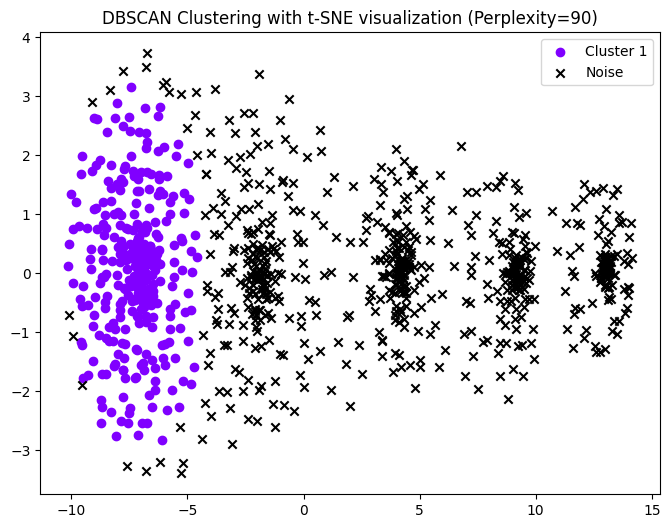

In [ ]:
# Zastosowanie algorytmu DBSCAN do identyfikacji klastrów
dbscan = DBSCAN(eps=3, min_samples=50)
# Klasyfikacja punktów do klastrów lub jako szum (wartość -1)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Obliczanie liczby zidentyfikowanych klastrów (pomijając szum)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Prezentacja wyników klasteryzacji DBSCAN na danych z t-SNE
colors = cm.rainbow(np.linspace(0, 1, n_clusters))  # Generowanie palety kolorów dla klastrów
plt.figure(figsize=(8, 6))
for i, color in enumerate(colors):
    if i != -1:  # Pomijanie punktów sklasyfikowanych jako szum
        xy = tsne_results[dbscan_labels == i]
        plt.scatter(xy[:, 0], xy[:, 1], color=color, label=f'Klaster {i+1}' if i != -1 else 'Szum')
# Dodanie punktów sklasyfikowanych jako szum
xy = tsne_results[dbscan_labels == -1]
plt.scatter(xy[:, 0], xy[:, 1], color='k', marker='x', label='Szum')
plt.title(f'Klasteryzacja metodą DBSCAN z wizualizacją t-SNE (Perpleksja={perplexity_value})')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


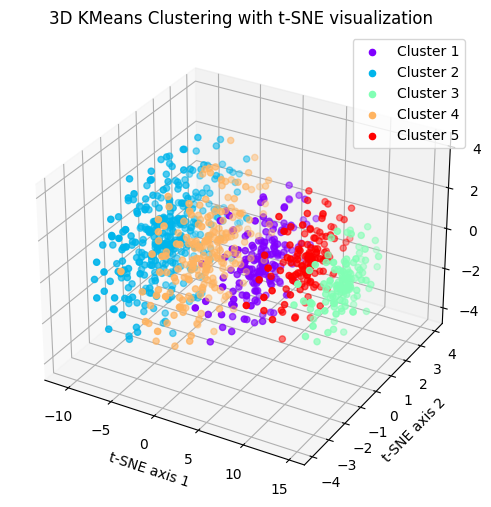

In [ ]:
# Wykorzystanie algorytmu t-SNE do redukcji wymiarowości danych
# Ustawiamy liczbę komponentów na 3, aby uzyskać trójwymiarową reprezentację
tsne = TSNE(n_components=3, perplexity=perplexity_value, random_state=0)
tsne_results = tsne.fit_transform(encoded_imgs_2d)

# Stosowanie KMeans na wynikach t-SNE
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans_labels = kmeans.fit_predict(tsne_results)

# Tworzenie wykresu 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Tworzenie mapy kolorów
colors = cm.rainbow(np.linspace(0, 1, optimal_k))

# Rysowanie punktów dla każdego klastra
for i, color in zip(range(optimal_k), colors):
    ax.scatter(tsne_results[kmeans_labels == i, 0],
               tsne_results[kmeans_labels == i, 1],
               tsne_results[kmeans_labels == i, 2],
               color=color,
               label=f'Cluster {i+1}')

# Ustawienie tytułu i etykiet osi
ax.set_title('3D KMeans Clustering with t-SNE visualization')
ax.set_xlabel('t-SNE axis 1')
ax.set_ylabel('t-SNE axis 2')
ax.set_zlabel('t-SNE axis 3')
ax.legend()

# Wyświetlenie wykresu
plt.show()

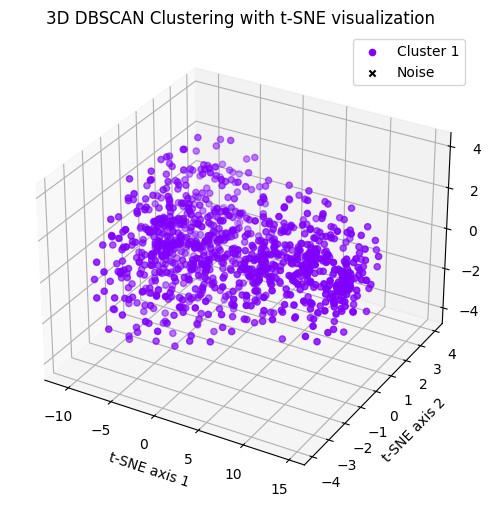

In [ ]:
# Wykorzystanie algorytmu t-SNE do redukcji wymiarowości danych
# Ustawiamy liczbę komponentów na 3, aby uzyskać trójwymiarową reprezentację
tsne = TSNE(n_components=3, perplexity=perplexity_value, random_state=0)
tsne_results = tsne.fit_transform(encoded_imgs_2d)

dbscan = DBSCAN(eps=20, min_samples=95)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Liczba wykrytych klastrów (ignorując szum)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Tworzenie wykresu 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Tworzenie mapy kolorów
colors = cm.rainbow(np.linspace(0, 1, n_clusters))

# Rysowanie punktów dla każdego klastra
for i, color in enumerate(colors):
    if i != -1:  # Ignorowanie szumu
        ax.scatter(tsne_results[dbscan_labels == i, 0],
                   tsne_results[dbscan_labels == i, 1],
                   tsne_results[dbscan_labels == i, 2],
                   color=color,
                   label=f'Cluster {i+1}')

# Rysowanie punktów szumu w czarnym kolorze
ax.scatter(tsne_results[dbscan_labels == -1, 0],
           tsne_results[dbscan_labels == -1, 1],
           tsne_results[dbscan_labels == -1, 2],
           color='k',
           marker='x',
           label='Noise')

# Ustawienie tytułu i etykiet osi
ax.set_title('3D DBSCAN Clustering with t-SNE visualization')
ax.set_xlabel('t-SNE axis 1')
ax.set_ylabel('t-SNE axis 2')
ax.set_zlabel('t-SNE axis 3')
ax.legend()

# Wyświetlenie wykresu
plt.show()

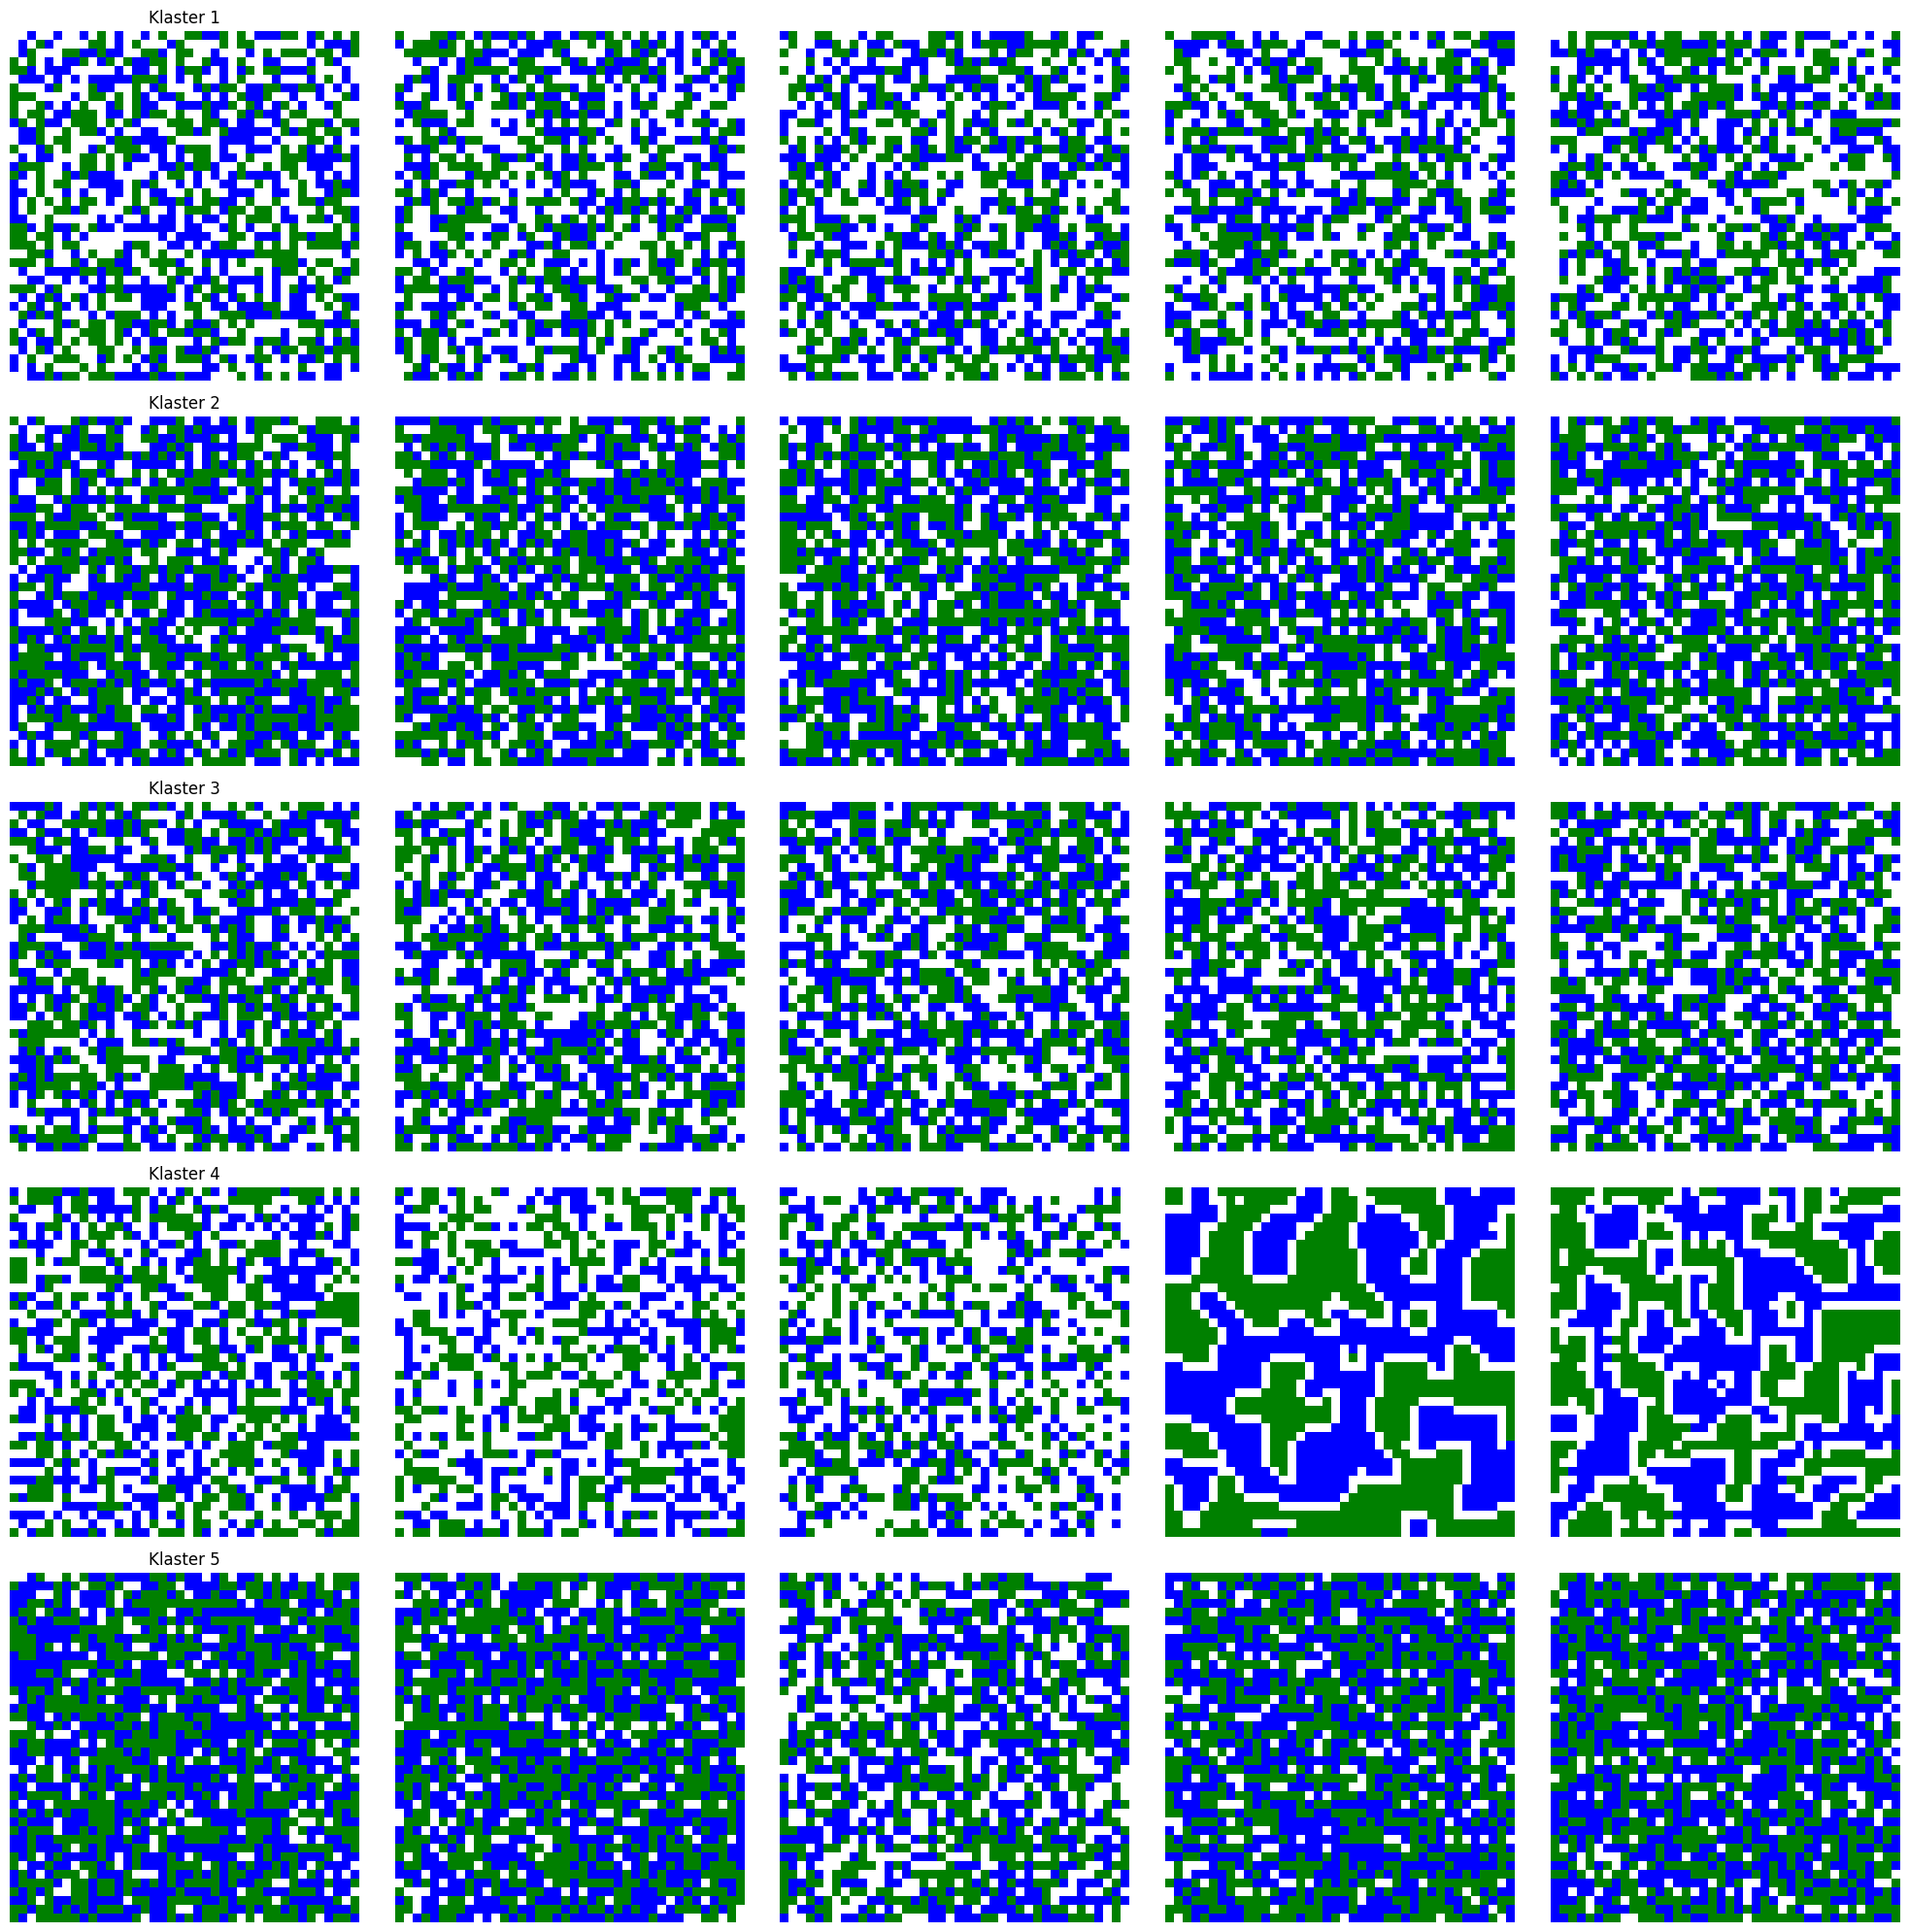

In [ ]:
num_images_per_cluster = 5

unique_labels = np.unique(kmeans_labels)
total_clusters = len(unique_labels)
fig, axes = plt.subplots(total_clusters, num_images_per_cluster, figsize=(num_images_per_cluster * 4, total_clusters * 4))

for label in unique_labels:
    # Znajdowanie indeksów obrazów należących do danego klastra
    indices = np.where(kmeans_labels == label)[0]
    num_images = min(len(indices), num_images_per_cluster)
    selected_indices = np.random.choice(indices, num_images, replace=False)

    for i in range(num_images_per_cluster):
        ax = axes[label, i]
        if i < num_images:
            idx = selected_indices[i]
            ax.imshow(x_test[idx])
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Klaster {label + 1}")
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()

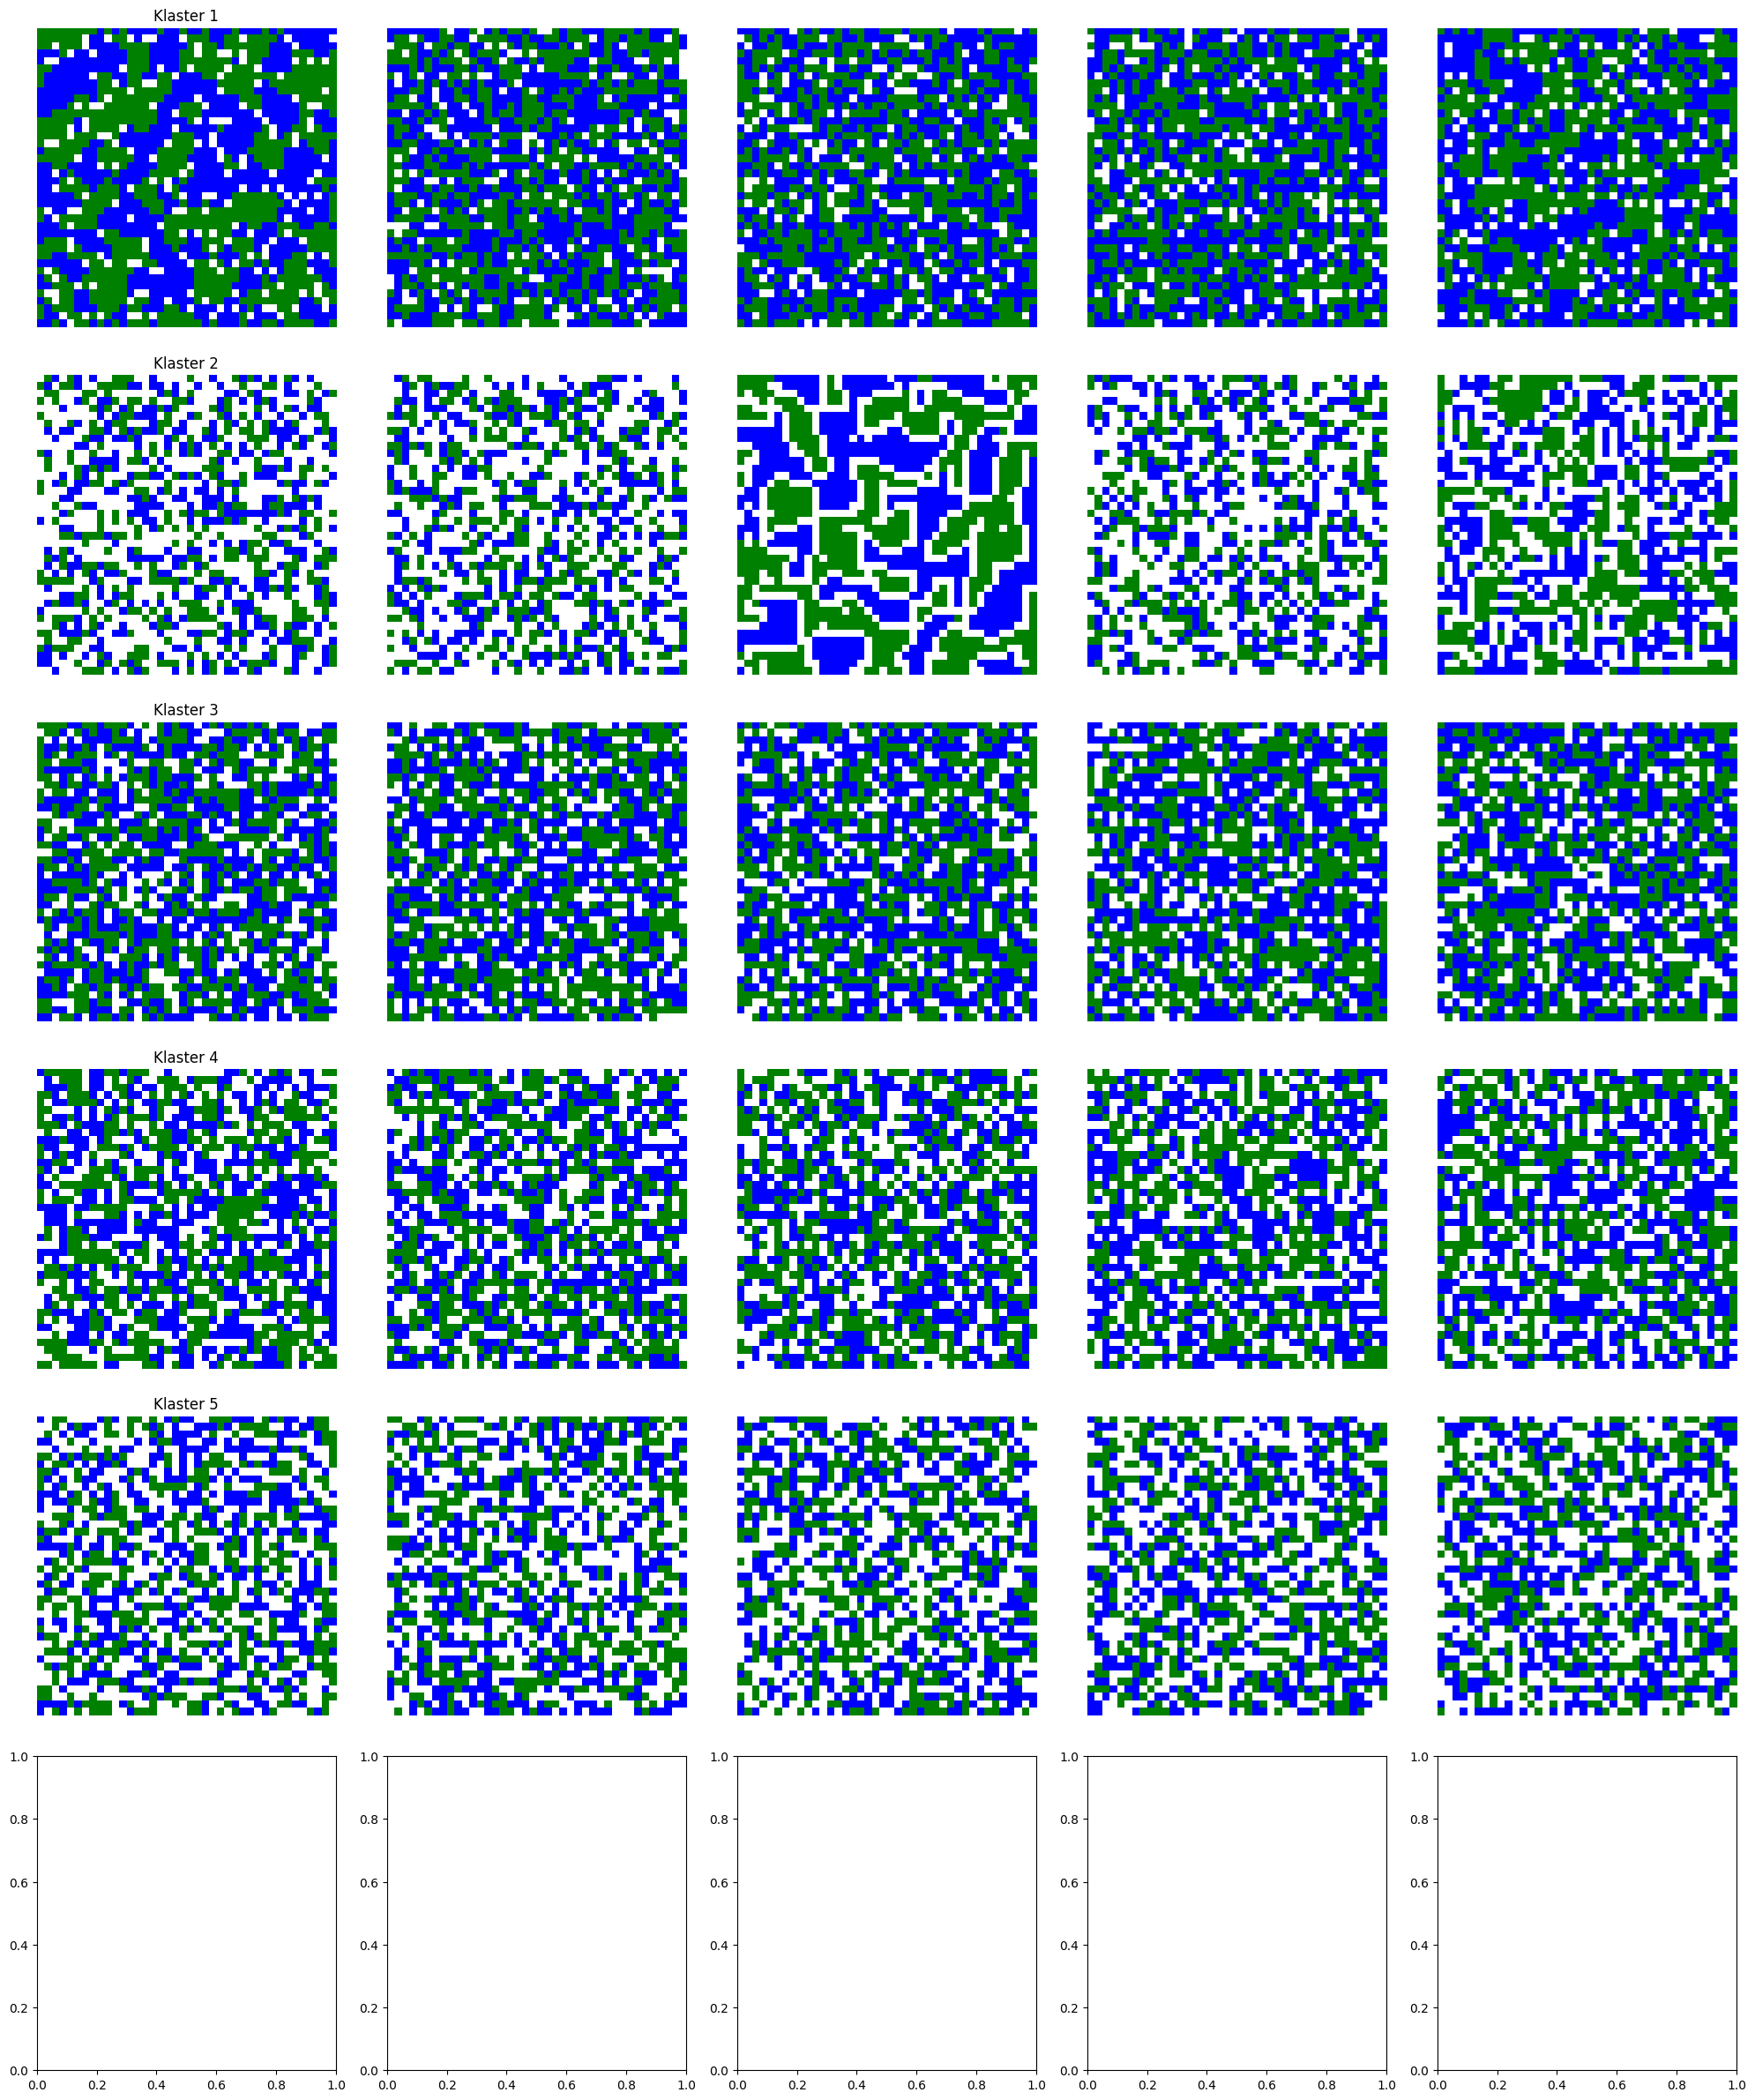

In [ ]:
num_images_per_cluster = 5

unique_labels = np.unique(dbscan_labels)
total_clusters = len(unique_labels)
fig, axes = plt.subplots(total_clusters, num_images_per_cluster, figsize=(num_images_per_cluster * 4, total_clusters * 4))

for label in unique_labels:
    if label == -1:
        # Pomijamy punkty oznaczone jako szum (-1)
        continue

    # Znajdowanie indeksów obrazów należących do danego klastra
    indices = np.where(dbscan_labels == label)[0]
    num_images = min(len(indices), num_images_per_cluster)
    selected_indices = np.random.choice(indices, num_images, replace=False)

    for i in range(num_images_per_cluster):
        ax = axes[label, i]
        if i < num_images:
            idx = selected_indices[i]
            ax.imshow(x_test[idx])
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Klaster {label + 1}")
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()